# Global Artists Analysis Using MusicBrainz, CountryInfo and Spotify API

## Data Cleaning and Transformation

This section covers the data preparation and enrichment process using multiple APIs:

- **MusicBrainz Data**:
  - Fetches artist data using genre tags
  - Extracts and standardizes dates and lifespans
  - Removes non-English character names
  - Filters out statistical outliers

- **Country Information**:
  - Retrieves geographical and demographic data
  - Standardizes country names for matching
  - Links artists to their countries of origin

- **Spotify Integration**:
  - Authenticates using OAuth 2.0 credentials
  - Fetches artist metrics (followers, popularity)
  - Adds streaming platform URLs
  - Enriches artist profiles with current data

The cleaned dataset combines historical records with current streaming metrics to enable comprehensive analysis of artist impact and reach.

### Fetch Artists from MusicBrainz

This cell fetches artist data from the MusicBrainz API using a specified genre tag (e.g., "Metal"):

- **API requests**: Loops through paginated results to collect up to `number_of_artists` artists.
- **Error handling**: Checks for valid responses and handles JSON errors.
- **Data collection**: Appends each batch of artists to a list and prints progress.
- **DataFrame creation**: Converts the list of fetched artists into a pandas DataFrame.

Notes: API is limited for 100 results per request, this is the reason I use a loop.

In [347]:
import requests
import pandas as pd

number_of_artists = 300
tag_query = "Hard Rock"

fetched_artists = []
for offset in range(2, number_of_artists + 2, 100):
    url = f"https://musicbrainz.org/ws/2/artist?query=tag:{tag_query}&limit=100&offset={offset}&fmt=json"
    response = requests.get(url)

    if response.status_code == 200 and response.content:
        try:
            data = response.json()
            # Adds each artist to the list, use .get() to prevent crash
            fetched_artists.extend(data.get('artists', []))
            print(f"Fetched {len(data.get('artists', []))} artists from offset {offset}.")
        except ValueError:
            print("Response content is not valid JSON.")
    else:
        print("No content or bad response:", response.status_code)
        break

print(f"Total artists fetched: {len(fetched_artists)}")

df = pd.DataFrame(fetched_artists)

Fetched 100 artists from offset 2.
Fetched 100 artists from offset 102.
Fetched 100 artists from offset 202.
Total artists fetched: 300


### Extract and Clean Artist Data

Processes raw MusicBrainz data to create clean, analyzable dataset:
- Use json_normalize() to flatten the nested keys into new columns.
- Format the dates columns to years, as some were of type 'yyyy-mm-dd' and others 'yyyy'.
- Creates standardized columns (country, dates, status).
- Calculates artist lifespans.
- Removes non-English names.
- Handles missing values.

Result: Clean DataFrame with artist career timeline data.

In [333]:
# Function to extract the year from a date string
def extract_year(date_str):
    if pd.isna(date_str):
        return None
    year = str(date_str)[:4]
    if year.isdigit():
        return int(year)
    else:
        return None

df = pd.json_normalize(fetched_artists)
df = df.set_index('id').sort_values(by='score', ascending=False)
df['Country_name'] = df['area.name']
df['Begin_date'] = df['life-span.begin']
df['End_date'] = df['life-span.end']
df['Ended'] = df['life-span.ended'].replace({None: False, True: True})
df['Year_formed'] = df['Begin_date'].apply(extract_year).astype('Int64')
df['Year_disbanded'] = df['End_date'].apply(extract_year).astype('Int64')
df['Lifespan'] = df['Year_disbanded']-df['Year_formed']


# remove any band names that aren't written in english characters
is_english = df['name'].apply(lambda x: str(x).isascii())
df = df[is_english]

print(f"Total rows after cleaning: {len(df)}")
df.info()

Total rows after cleaning: 97
<class 'pandas.core.frame.DataFrame'>
Index: 97 entries, b10bbbfc-cf9e-42e0-be17-e2c3e1d2600d to 0d4696bc-6a04-4525-80a8-40308054b91c
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   type                        87 non-null     object 
 1   type-id                     87 non-null     object 
 2   score                       97 non-null     int64  
 3   name                        97 non-null     object 
 4   sort-name                   97 non-null     object 
 5   country                     82 non-null     object 
 6   disambiguation              60 non-null     object 
 7   isnis                       62 non-null     object 
 8   aliases                     65 non-null     object 
 9   tags                        71 non-null     object 
 10  area.id                     88 non-null     object 
 11  area.type                   88 non-null     object 
 12  

C:\Users\omerm\AppData\Local\Temp\ipykernel_21900\3763812111.py:16: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



### Select Relevant Artist Features

This cell creates a new DataFrame containing only the relevant columns for analysis:

- **name**: Artist or band name.
- **Country_name**: Country of origin.
- **Year_formed**: Year the artist or band was formed.
- **Year_disbanded**: Year the artist or band disbanded (if applicable).
- **Ended**: Whether the artist or band has ended their career.
- **Lifespan**: Duration of the Artist's activity.


In [334]:
artist_df = df[['name', 'Country_name','Year_formed','Year_disbanded','Ended','Lifespan']].copy()
artist_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97 entries, b10bbbfc-cf9e-42e0-be17-e2c3e1d2600d to 0d4696bc-6a04-4525-80a8-40308054b91c
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   name            97 non-null     object
 1   Country_name    88 non-null     object
 2   Year_formed     74 non-null     Int64 
 3   Year_disbanded  22 non-null     Int64 
 4   Ended           97 non-null     bool  
 5   Lifespan        21 non-null     Int64 
dtypes: Int64(3), bool(1), object(2)
memory usage: 4.9+ KB


### Fetch and Prepare Country Data

This cell retrieves country information using the `countryinfo` library and prepares a DataFrame for analysis:

- Fetches all country data from the CountryInfo package.
- Converts the country data into a pandas DataFrame and resets the index.
- Keeps only relevant columns: country name, area, capital, population, and region.
- Renames the 'name' column to 'Country_name' for consistency.

In [335]:
from countryinfo import CountryInfo

# Get all country names from countryinfo
fetch_countries = CountryInfo().all()

countries_df = pd.DataFrame(fetch_countries).T
countries_df.reset_index(inplace=True)
countries_df = countries_df[['name', 'area', 'capital', 'population', 'region']]
countries_df.rename(columns={'name': 'Country_name'}, inplace=True)
countries_df.sample(5)



,Country_name,area,capital,population,region
184,Senegal,196722,Dakar,13508715,Africa
42,Cocos (Keeling) Islands,14,West Island,550,Oceania
46,Democratic Republic of the Congo,2344858,Kinshasa,69360000,Africa
24,Bosnia and Herzegovina,51209,Sarajevo,3791622,Europe
115,Lebanon,10452,Beirut,4104000,Asia


### Filter Artists by Valid Country Names

This cell ensures that only artists from recognized countries are included in the analysis:

- Keeps only rows in `artist_df` where `Country_name` matches a valid country from the country DataFrame.
- Sets the 'Ended' column to `False` for artists with no disbanded year.
- Displays the structure and column types of the filtered

In [336]:
valid_countries = countries_df['Country_name'].str.lower()
artist_df = artist_df[artist_df['Country_name'].str.lower().isin(valid_countries)].copy()
artist_df.loc[artist_df['Year_disbanded'].isna(), 'Ended'] = False
artist_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 82 entries, b10bbbfc-cf9e-42e0-be17-e2c3e1d2600d to 0d4696bc-6a04-4525-80a8-40308054b91c
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   name            82 non-null     object
 1   Country_name    82 non-null     object
 2   Year_formed     69 non-null     Int64 
 3   Year_disbanded  20 non-null     Int64 
 4   Ended           82 non-null     bool  
 5   Lifespan        19 non-null     Int64 
dtypes: Int64(3), bool(1), object(2)
memory usage: 6.2+ KB


### Enrich Artist Data with Spotify Information

This cell adds artist information from Spotify API:
- Number of followers
- Artist popularity score (0-100)
- Spotify profile URL
- Spotify profile image
- Genre tags

The data enrichment:
1. Creates a Spotify API client with authentication
2. Searches for each artist by name
3. Retrieves their profile metrics
4. Adds the data to new columns in our DataFrame

In [337]:
import base64
import requests
from datetime import datetime, timedelta

class SpotifyAPI:
    def __init__(self, client_id, client_secret):
        self.client_id = client_id
        self.client_secret = client_secret
        self.token = None
        self.token_expiry = None
        
    def get_token(self):
        """Generate or return existing valid token"""
        if self.token and self.token_expiry > datetime.now():
            return self.token
            
        # Prepare authentication string
        auth_string = f"{self.client_id}:{self.client_secret}"
        auth_bytes = auth_string.encode('utf-8')
        auth_base64 = base64.b64encode(auth_bytes).decode('utf-8')
        
        url = "https://accounts.spotify.com/api/token"
        headers = {
            "Authorization": f"Basic {auth_base64}",
            "Content-Type": "application/x-www-form-urlencoded"
        }
        data = {"grant_type": "client_credentials"}
        
        result = requests.post(url, headers=headers, data=data)
        if result.status_code == 200:
            json_result = result.json()
            self.token = json_result.get('access_token')
            self.token_expiry = datetime.now() + timedelta(seconds=json_result.get('expires_in', 3600))
            return self.token
        else:
            raise Exception(f"Failed to get token: {result.status_code}")
            
    def search_artist(self, artist_name):
        """Search for an artist and return their details"""
        token = self.get_token()
        
        url = "https://api.spotify.com/v1/search"
        headers = {
            "Authorization": f"Bearer {token}"
        }
        params = {
            "q": artist_name,
            "type": "artist",
            "limit": 1  # Get only the top result
        }
        
        result = requests.get(url, headers=headers, params=params)
        if result.status_code == 200:
            json_result = result.json()
            artists = json_result.get('artists', {}).get('items', [])
            return artists[0] if artists else None
        else:
            print(f"Error searching for artist: {result.status_code}")
            return None


spotify = SpotifyAPI(
    client_id="8686729aa3634173bc1f6440a9564bca",
    client_secret="56ed0c0950434304866ac26490c0353b"
)

# Test with a single artist

test_artist = "Metallica"
result = spotify.search_artist(test_artist)
result
# if result:
#     print(f"Artist: {result['name']}")
#     print(f"Popularity: {result['popularity']}")
#     print(f"Followers: {result['followers']['total']}")
#     print(f"Genres: {', '.join(result['genres'])}")
#     print(f"Spotify URL: {result['external_urls']['spotify']}")
# else:
#     print(f"No results found for {test_artist}")

{'external_urls': {'spotify': 'https://open.spotify.com/artist/2ye2Wgw4gimLv2eAKyk1NB'},
 'followers': {'href': None, 'total': 31169573},
 'genres': ['metal', 'thrash metal', 'rock', 'heavy metal', 'hard rock'],
 'href': 'https://api.spotify.com/v1/artists/2ye2Wgw4gimLv2eAKyk1NB',
 'id': '2ye2Wgw4gimLv2eAKyk1NB',
 'images': [{'url': 'https://i.scdn.co/image/ab6761610000e5eb69ca98dd3083f1082d740e44',
   'height': 640,
   'width': 640},
  {'url': 'https://i.scdn.co/image/ab6761610000517469ca98dd3083f1082d740e44',
   'height': 320,
   'width': 320},
  {'url': 'https://i.scdn.co/image/ab6761610000f17869ca98dd3083f1082d740e44',
   'height': 160,
   'width': 160}],
 'name': 'Metallica',
 'popularity': 86,
 'type': 'artist',
 'uri': 'spotify:artist:2ye2Wgw4gimLv2eAKyk1NB'}

In [338]:
def enrich_artist_with_spotify_data(artist_df, spotify_client):
    """
    Add Spotify metrics (followers, URL) to the artist DataFrame
    """
    # Initialize new columns
    artist_df['spotify_followers'] = None
    artist_df['spotify_url'] = None
    artist_df['spotify_popularity'] = None
    artist_df['spotify_image'] = None
    
    # Process each artist
    for idx, row in artist_df.iterrows():
        artist_name = row['name']
        result = spotify_client.search_artist(artist_name)
        
        if result:
            artist_df.at[idx, 'spotify_followers'] = result['followers']['total']
            artist_df.at[idx, 'spotify_url'] = result['external_urls']['spotify']
            artist_df.at[idx, 'spotify_popularity'] = result['popularity']
            # Safely get the first image URL if available
            if result.get('images') and len(result['images']) > 0:
                artist_df.at[idx, 'spotify_image'] = result['images'][0]['url']
            else:
                artist_df.at[idx, 'spotify_image'] = None
            print(f"Found Spotify data for {artist_name}")
        else:
            print(f"No Spotify data found for {artist_name}")
            
        # Add a small delay to avoid rate limiting
        time.sleep(0.1)
    
    return artist_df


import time

# Add Spotify data to artist_df
artist_df = enrich_artist_with_spotify_data(artist_df, spotify)

# Display some statistics
print("\nSpotify Data Summary:")
print(f"Artists with Spotify profiles: {artist_df['spotify_followers'].notna().sum()}")
print(f"Average followers: {artist_df['spotify_followers'].mean():,.0f}")
print(f"Average popularity: {artist_df['spotify_popularity'].mean():.1f}")

artist_df.head()



Found Spotify data for The Beatles
Found Spotify data for Elvis Presley
Found Spotify data for Aesop Rock
Found Spotify data for U2
Found Spotify data for worry rock
Found Spotify data for Pete Rock
Found Spotify data for The Rolling Stones
Found Spotify data for KISS
Found Spotify data for Pearl Jam
Found Spotify data for Queen
Found Spotify data for Shlock Rock
Found Spotify data for The Beach Boys
Found Spotify data for Datarock
Found Spotify data for Mondo Rock
Found Spotify data for Led Zeppelin
Found Spotify data for Brighton Rock
Found Spotify data for AC/DC
Found Spotify data for Metallica
Found Spotify data for Rush
Found Spotify data for ONE OK ROCK
Found Spotify data for Zarpa
Found Spotify data for Genesis
Found Spotify data for TV Rock
Found Spotify data for Status Quo
Found Spotify data for R.E.M.
Found Spotify data for Nirvana
Found Spotify data for Neil Young
Found Spotify data for Wilco
Found Spotify data for Jay Rock
Found Spotify data for Scorpions
Found Spotify data

,name,Country_name,Year_formed,Year_disbanded,Ended,Lifespan,spotify_followers,spotify_url,spotify_popularity,spotify_image
id,,,,,,,,,,
b10bbbfc-cf9e-42e0-be17-e2c3e1d2600d,The Beatles,United Kingdom,1960,1970,True,10,30169911,https://open.spotify.com/artist/3WrFJ7ztbogyGn...,86,https://i.scdn.co/image/ab6761610000e5ebe9348c...
01809552-4f87-45b0-afff-2c6f0730a3be,Elvis Presley,United States,1935,1977,True,42,10744030,https://open.spotify.com/artist/43ZHCT0cAZBISj...,80,https://i.scdn.co/image/ab6761610000e5eb9a93e2...
aba64937-3334-4c65-90a1-4e6b9d4d7ada,Aesop Rock,United States,1976,<NA>,False,<NA>,480175,https://open.spotify.com/artist/2fSaE6BXtQy0x7...,60,https://i.scdn.co/image/ab6761610000e5eb9cafc1...
a3cb23fc-acd3-4ce0-8f36-1e5aa6a18432,U2,Ireland,1976,<NA>,False,<NA>,13359664,https://open.spotify.com/artist/51Blml2LZPmy7T...,80,https://i.scdn.co/image/ab6761610000e5ebe62be2...
7fcb4c4c-5d40-4cdd-9802-f19c477d58b9,worry rock,United States,<NA>,<NA>,False,<NA>,42489,https://open.spotify.com/artist/79yGLYvB762fzc...,35,https://i.scdn.co/image/ab6761610000e5eb7f37bb...


## Plot Analysis

This section visualizes key insights from the cleaned artist and country data:

- Distribution of artists by country.
- Histogram of years when bands were formed.
- Pie chart of active vs. disbanded artists.
- Average lifespan of artists by country.
- Scatter plot of year formed vs. lifespan.
- Trends in band formation over time.
- Geographic visualization of bands formed by country.
- Artists per million people by country.

These plots help reveal patterns and trends in the global distribution and activity of artists.

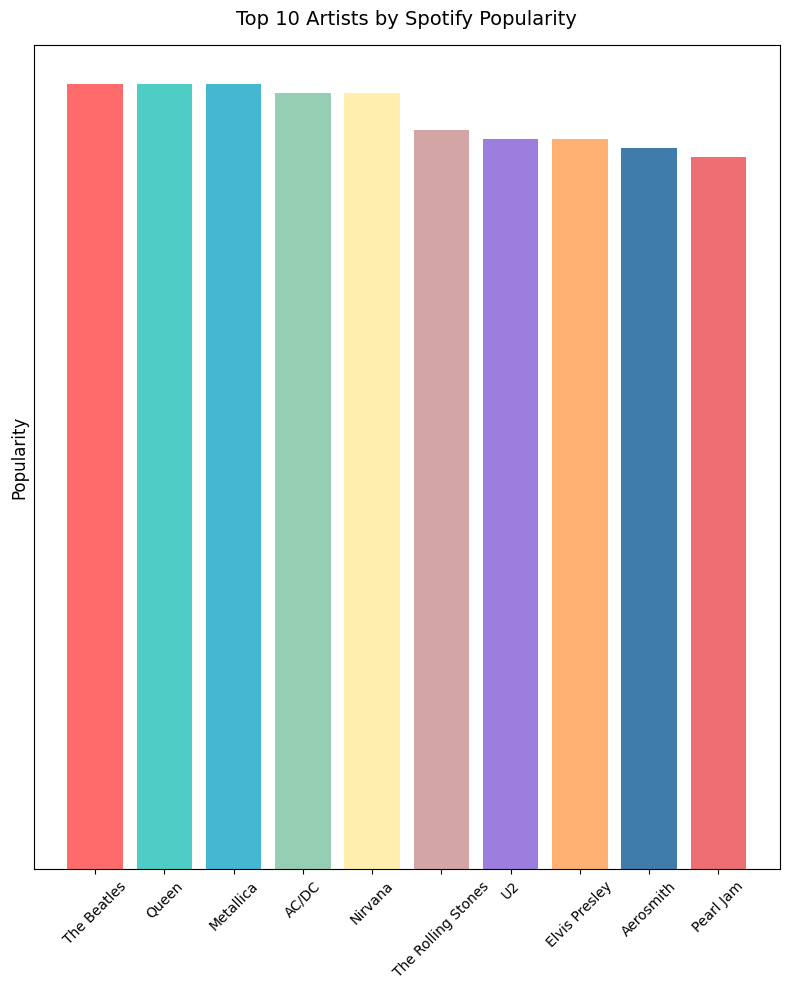

In [349]:
import matplotlib.pyplot as plt

top_artists = artist_df.sort_values('spotify_popularity', ascending=False).head(10)

colors_sunset = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEEAD',
                 '#D4A5A5', '#9B7EDE', '#FFB174', '#3F7CAC', '#EE6E73']

plt.figure(figsize=(8, 10))
plt.bar(top_artists['name'], top_artists['spotify_popularity'], color=colors_sunset)
plt.title('Top 10 Artists by Spotify Popularity', fontsize=14, pad=15)
plt.ylabel('Popularity', fontsize=12)
# plt.ylim(70,95)
plt.xticks(rotation=45, fontsize=10)
plt.yticks([])  # removes y values from plot
plt.tight_layout()
plt.savefig('plots/topArtistsByPopularity.png')
plt.show()
 

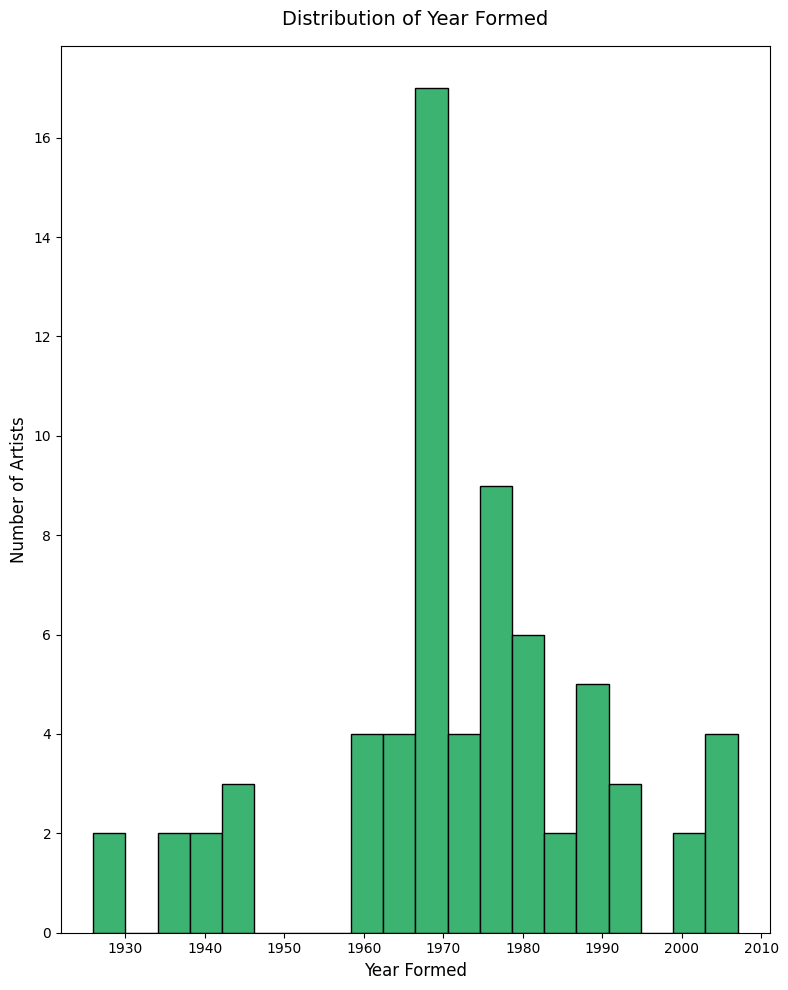

In [340]:
plt.figure(figsize=(8, 10))
artist_df['Year_formed'].plot(
    kind='hist',
    bins=20,
    color='mediumseagreen',
    edgecolor='black'
)
plt.title('Distribution of Year Formed', fontsize=14, pad=15)
plt.xlabel('Year Formed', fontsize=12)
plt.ylabel('Number of Artists', fontsize=12)
plt.tight_layout()
plt.savefig('plots/DistOfYearFormed.png')
plt.show()


In [341]:
average_lifespan = artist_df['Lifespan'].mean()
print(f"Average artist lifespan: {average_lifespan:.2f} years")

Average artist lifespan: 43.26 years


In [342]:
import plotly.express as px

custom_colors = [
    [0, "#f7fbff"],      # Lightest shade
    [0.2, "#deebf7"],
    [0.4, "#c6dbef"],
    [0.6, "#9ecae1"],
    [0.8, "#4292c6"],
    [1, "#084594"]       # Darkest shade
]
# Prepare data: count *active* bands per country
active_artists = artist_df[artist_df['Ended'] == False]
active_counts = active_artists['Country_name'].value_counts().reset_index()
active_counts.columns = ['Country_name', 'ActiveBands']

fig = px.choropleth(
    active_counts,
    locations="Country_name",
    locationmode="country names",
    color="ActiveBands",
    color_continuous_scale='Viridis',
    title="Number of Active Artists by Country",
    labels={'ActiveBands': 'Active Artists'},
    width=800,
    height=400
)
fig.update_geos(showcoastlines=True, showland=True, landcolor="#FFFFFF")
fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig.write_image("plots/ActiveArtistsByCountryMap.png", width=800, height=400, scale=2)
fig.show()

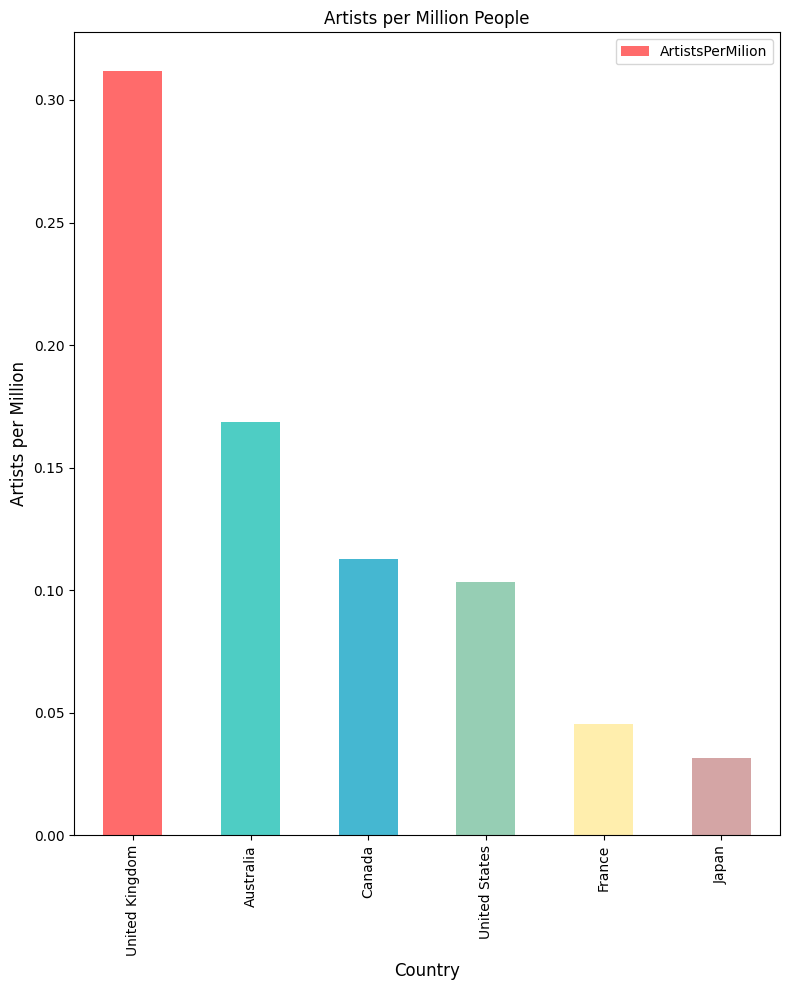

In [343]:
merged_df = pd.merge(artist_df, countries_df, left_on='Country_name', right_on='Country_name', how='left')

artist_per_country = merged_df.groupby('Country_name')['name'].count().reset_index()
artist_per_country = artist_per_country.rename(columns={'name': 'ArtistsCount'})
artist_per_country = artist_per_country.merge(countries_df[['Country_name', 'population']], on='Country_name', how='left')
artist_per_country['ArtistsPerMilion'] = (artist_per_country['ArtistsCount'] / artist_per_country['population']) * 1_000_000

top_countries = artist_per_country.sort_values('ArtistsPerMilion', ascending=False)
# Remove countries with less than 5 Arirsts
top_countries = top_countries[top_countries['ArtistsCount'] >= 3].head(10)
# Plot
colors_sunset = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEEAD',
                 '#D4A5A5', '#9B7EDE', '#FFB174', '#3F7CAC', '#EE6E73']
top_countries.plot(
    x='Country_name',
    y='ArtistsPerMilion',
    kind='bar',
    figsize=(8, 10),
    title='Artists per Million People',
    color=colors_sunset
)

plt.ylabel('Artists per Million', fontsize=12)
plt.xlabel('Country', fontsize=12)
plt.tight_layout()
plt.savefig('plots/ArtistsPerMillion.png')
plt.show()

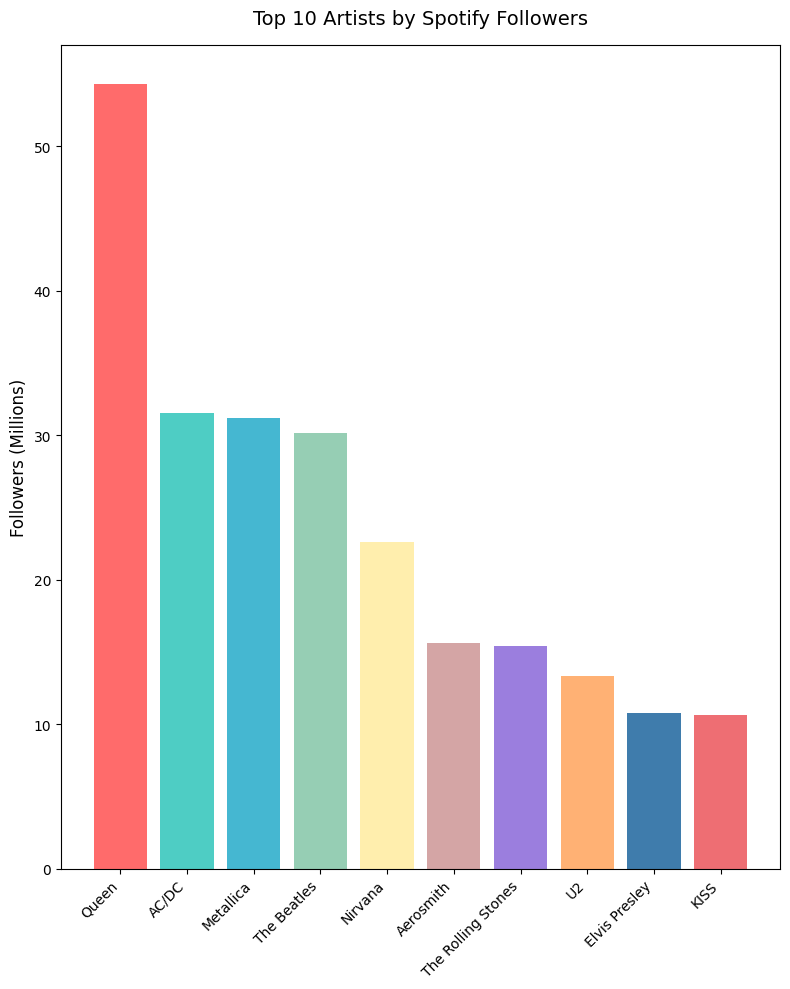

In [344]:
# Create a top 10 most followed artists visualization
plt.figure(figsize=(8, 10))
top_10_by_followers = artist_df['spotify_followers'].sort_values(ascending=False).head(10)
top_10_artists = artist_df.loc[top_10_by_followers.index]

# Convert followers to millions for easier reading
followers_in_millions = top_10_artists['spotify_followers'] / 1_000_000

plt.bar(
    top_10_artists['name'],
    followers_in_millions,
    color=colors_sunset,
)

plt.title('Top 10 Artists by Spotify Followers', fontsize=14, pad=15)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Followers (Millions)', fontsize=12)
plt.tight_layout()
plt.savefig('plots/topArtistsByFollowers.png')
plt.show()

In [345]:
artist_df.head()

,name,Country_name,Year_formed,Year_disbanded,Ended,Lifespan,spotify_followers,spotify_url,spotify_popularity,spotify_image
id,,,,,,,,,,
b10bbbfc-cf9e-42e0-be17-e2c3e1d2600d,The Beatles,United Kingdom,1960,1970,True,10,30169911,https://open.spotify.com/artist/3WrFJ7ztbogyGn...,86,https://i.scdn.co/image/ab6761610000e5ebe9348c...
01809552-4f87-45b0-afff-2c6f0730a3be,Elvis Presley,United States,1935,1977,True,42,10744030,https://open.spotify.com/artist/43ZHCT0cAZBISj...,80,https://i.scdn.co/image/ab6761610000e5eb9a93e2...
aba64937-3334-4c65-90a1-4e6b9d4d7ada,Aesop Rock,United States,1976,<NA>,False,<NA>,480175,https://open.spotify.com/artist/2fSaE6BXtQy0x7...,60,https://i.scdn.co/image/ab6761610000e5eb9cafc1...
a3cb23fc-acd3-4ce0-8f36-1e5aa6a18432,U2,Ireland,1976,<NA>,False,<NA>,13359664,https://open.spotify.com/artist/51Blml2LZPmy7T...,80,https://i.scdn.co/image/ab6761610000e5ebe62be2...
7fcb4c4c-5d40-4cdd-9802-f19c477d58b9,worry rock,United States,<NA>,<NA>,False,<NA>,42489,https://open.spotify.com/artist/79yGLYvB762fzc...,35,https://i.scdn.co/image/ab6761610000e5eb7f37bb...



Top 10 Artists with their Spotify URLs and Images:

1. Queen
   🎵 Listen: https://open.spotify.com/artist/1dfeR4HaWDbWqFHLkxsg1d
   🖼️ Image:


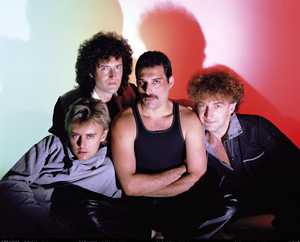

--------------------------------------------------

2. AC/DC
   🎵 Listen: https://open.spotify.com/artist/711MCceyCBcFnzjGY4Q7Un
   🖼️ Image:


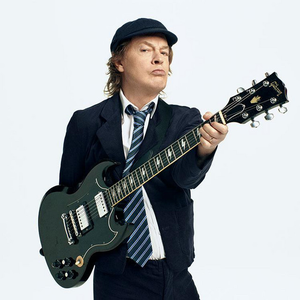

--------------------------------------------------

3. Metallica
   🎵 Listen: https://open.spotify.com/artist/2ye2Wgw4gimLv2eAKyk1NB
   🖼️ Image:


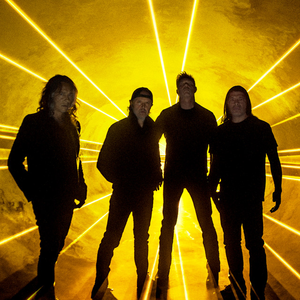

--------------------------------------------------

4. The Beatles
   🎵 Listen: https://open.spotify.com/artist/3WrFJ7ztbogyGnTHbHJFl2
   🖼️ Image:


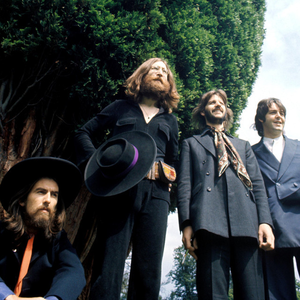

--------------------------------------------------

5. Nirvana
   🎵 Listen: https://open.spotify.com/artist/6olE6TJLqED3rqDCT0FyPh
   🖼️ Image:


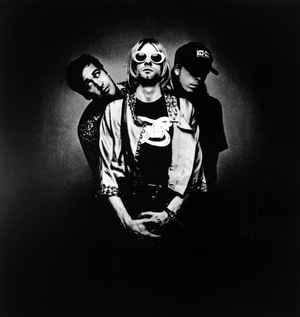

--------------------------------------------------

6. Aerosmith
   🎵 Listen: https://open.spotify.com/artist/7Ey4PD4MYsKc5I2dolUwbH
   🖼️ Image:


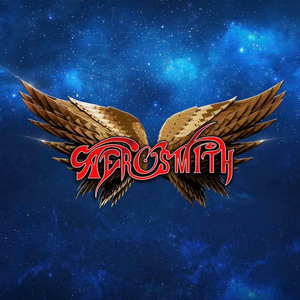

--------------------------------------------------

7. The Rolling Stones
   🎵 Listen: https://open.spotify.com/artist/22bE4uQ6baNwSHPVcDxLCe
   🖼️ Image:


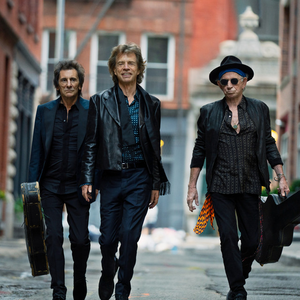

--------------------------------------------------

8. U2
   🎵 Listen: https://open.spotify.com/artist/51Blml2LZPmy7TTiAg47vQ
   🖼️ Image:


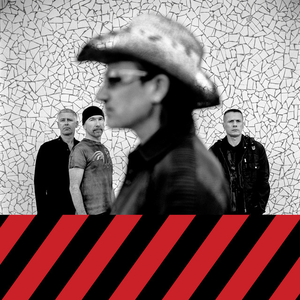

--------------------------------------------------

9. Elvis Presley
   🎵 Listen: https://open.spotify.com/artist/43ZHCT0cAZBISjO8DG9PnE
   🖼️ Image:


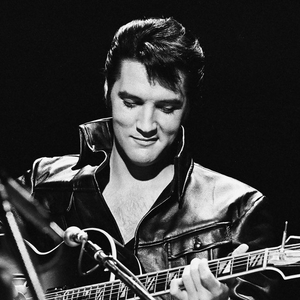

--------------------------------------------------

10. KISS
   🎵 Listen: https://open.spotify.com/artist/07XSN3sPlIlB2L2XNcTwJw
   🖼️ Image:


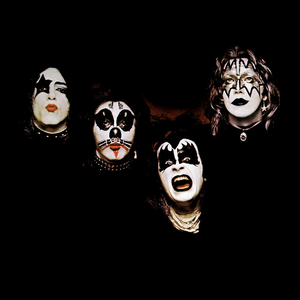

--------------------------------------------------


In [346]:
from io import BytesIO
from IPython.display import display
from PIL import Image as PILImage

def get_and_display_image(url, max_width=300):
    """Fetch and display image from URL in notebook with size limit"""
    try:
        response = requests.get(url)
        if response.status_code == 200:
            # Create image from bytes
            image = PILImage.open(BytesIO(response.content))
            
            # Calculate new height maintaining aspect ratio
            width_percent = max_width / float(image.size[0])
            new_height = int(float(image.size[1]) * width_percent)
            
            # Resize image
            image = image.resize((max_width, new_height), PILImage.Resampling.LANCZOS)
            
            # Display resized image
            display(image)
            return True
        return None
    except Exception as e:
        print(f"Error fetching image: {e}")
        return None

# Display artists with resized images
print("\nTop 10 Artists with their Spotify URLs and Images:")
top_5_artists = artist_df[['name', 'spotify_url', 'spotify_image','spotify_followers']].sort_values('spotify_followers', ascending=False).head(10)

for i, (idx, row) in enumerate(top_5_artists.iterrows(), 1):
    print(f"\n{i}. {row['name']}")
    print(f"   🎵 Listen: {row['spotify_url']}")
    print(f"   🖼️ Image:")
    get_and_display_image(row['spotify_image'], max_width=300)
    print("-" * 50)  # Separator between artists

In [2]:
!pip freeze > requirements.txt